In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.python.keras.layers import Dense, LSTM , Dropout, CuDNNLSTM
from tensorflow.python.keras import Sequential
import time
import os
import copy

In [28]:
dataset_path = "/kaggle/input/beijing-pm25-data-data-set"
! pip install -q datasets
!ls {dataset_path}
df = pd.read_csv("/kaggle/input/beijing-pm25-data-data-set/PRSA_data_2010.1.1-2014.12.31.csv")
df.rename(columns = {'pm2.5':'pm'}, inplace = True)

PRSA_data_2010.1.1-2014.12.31.csv


In [29]:
df.dropna(inplace=True)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm      41757 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.5+ MB
None
                 No          year         month           day          hour  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean   22279.380104   2012.042771      6.513758     15.685514     11.502311   
std    12658.168415      1.4153

In [30]:
df['month'] = df['month'].astype(str).str.pad(2,fillchar='0')
df['hour'] = df['hour'].astype(str).str.pad(2,fillchar='0')
df['time'] = df['day'].astype(str)+'-'+df['month'].astype(str)+'-'+df['year'].astype(str)+'-'+df['hour'].astype(str)
del df['year']
del df['month']
del df['day']
del df['hour']
del df['No']
df.head()

,pm,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2-01-2010-00
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2-01-2010-01
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2-01-2010-02
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2-01-2010-03
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2-01-2010-04


In [31]:
df['time'] = pd.to_datetime(df['time'], format="%d-%m-%Y-%H")
df['timestamp'] = df['time'].apply(lambda x: x.timestamp())
df['cbwd'].unique()
del df['time']
df = pd.get_dummies(df, columns=['cbwd'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pm         41757 non-null  float64
 1   DEWP       41757 non-null  int64  
 2   TEMP       41757 non-null  float64
 3   PRES       41757 non-null  float64
 4   Iws        41757 non-null  float64
 5   Is         41757 non-null  int64  
 6   Ir         41757 non-null  int64  
 7   timestamp  41757 non-null  float64
 8   cbwd_NE    41757 non-null  uint8  
 9   cbwd_NW    41757 non-null  uint8  
 10  cbwd_SE    41757 non-null  uint8  
 11  cbwd_cv    41757 non-null  uint8  
dtypes: float64(5), int64(3), uint8(4)
memory usage: 3.0 MB


In [32]:
scaler = MinMaxScaler()
df[['pm','DEWP','TEMP','PRES','Iws','Is','Ir']] = scaler.fit_transform(df[['pm','DEWP','TEMP','PRES','Iws','Is','Ir']])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pm         41757 non-null  float64
 1   DEWP       41757 non-null  float64
 2   TEMP       41757 non-null  float64
 3   PRES       41757 non-null  float64
 4   Iws        41757 non-null  float64
 5   Is         41757 non-null  float64
 6   Ir         41757 non-null  float64
 7   timestamp  41757 non-null  float64
 8   cbwd_NE    41757 non-null  uint8  
 9   cbwd_NW    41757 non-null  uint8  
 10  cbwd_SE    41757 non-null  uint8  
 11  cbwd_cv    41757 non-null  uint8  
dtypes: float64(8), uint8(4)
memory usage: 3.0 MB


,pm,DEWP,TEMP,PRES,Iws,Is,Ir,timestamp,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,0.129779,0.352941,0.245902,0.527273,0.002372,0.000000,0.0,1.262390e+09,0,0,1,0
25,0.148893,0.367647,0.245902,0.527273,0.003947,0.000000,0.0,1.262394e+09,0,0,1,0
26,0.159960,0.426471,0.229508,0.545455,0.005522,0.000000,0.0,1.262398e+09,0,0,1,0
27,0.182093,0.485294,0.229508,0.563636,0.008690,0.037037,0.0,1.262401e+09,0,0,1,0
28,0.138833,0.485294,0.229508,0.563636,0.010265,0.074074,0.0,1.262405e+09,0,0,1,0


In [55]:
seq_len = 5*24 # observe the data for the past 5 days
delay = 1*24 # predict the PM2.5 value one day after
df_reshaped= np.array([df.iloc[i : i + seq_len + delay].values for i in range(len(df) - seq_len - delay)])
df_tensor = tf.convert_to_tensor(df_reshaped, dtype=tf.float32)
df_reshaped.shape

(41613, 144, 12)

In [56]:
np.random.shuffle(df_reshaped)
# Split the data into x and y
x = df_reshaped[:, :5*24, df.columns != 'pm'].astype('float32')
y = df_reshaped[:, -1, df.columns.get_loc('pm')].astype('float32')
x.shape, y.shape
print("Values of x:")
print(x[0]) # print the first row of x
print("Values of y:")
print(y[0]) # print the first value of y

Values of x:
[[0.85294116 0.6721311  0.27272728 ... 1.         0.         0.        ]
 [0.86764705 0.704918   0.29090908 ... 1.         0.         0.        ]
 [0.86764705 0.72131145 0.29090908 ... 0.         0.         0.        ]
 ...
 [0.8088235  0.704918   0.45454547 ... 0.         0.         1.        ]
 [0.8235294  0.73770493 0.43636364 ... 0.         0.         1.        ]
 [0.8088235  0.75409836 0.43636364 ... 0.         1.         0.        ]]
Values of y:
0.06539235


In [57]:
split = int(y.shape[0]*0.8)
train_x = x[:split]
train_y = y[:split]
test_x = x[split:]
test_y = y[split:]
train_x.shape, test_x.shape

((33290, 120, 11), (8323, 120, 11))

In [61]:
#(33290, 120, 12) -> (batch, time for observation, features per observation)
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120, 11)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5632      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(optimizer='adam', loss='mae')
history = model.fit(train_x, train_y, batch_size=128, epochs=90,validation_data=(test_x, test_y))

Epoch 1/90
261/261 [==============================] - 4s 9ms/step - loss: 0.0661 - val_loss: 0.0663
Epoch 2/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0660 - val_loss: 0.0663
Epoch 3/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0660 - val_loss: 0.0663
Epoch 4/90
261/261 [==============================] - 2s 7ms/step - loss: 0.0661 - val_loss: 0.0664
Epoch 5/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0661 - val_loss: 0.0663
Epoch 6/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0660 - val_loss: 0.0663
Epoch 7/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0660 - val_loss: 0.0664
Epoch 8/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0661 - val_loss: 0.0664
Epoch 9/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0661 - val_loss: 0.0663
Epoch 10/90
261/261 [==============================] - 2s 8ms/step - loss: 0.0661 - val_loss: 0.0664

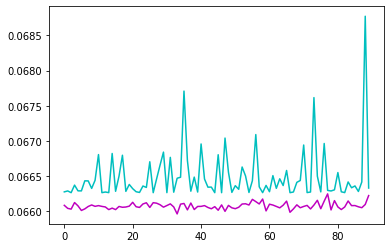

In [66]:
plt.plot(history.epoch, history.history['loss'], c='m')
plt.plot(history.epoch, history.history['val_loss'], c='c')

In [42]:
model.evaluate(test_x, test_y, verbose=0)

0.06580150127410889

In [67]:
test_predict = model.predict(test_x)
test_x.shape, test_predict.shape

((8323, 120, 11), (8323, 1))

In [68]:
test_predict[:5]

array([[0.06940077],
       [0.06940077],
       [0.06940077],
       [0.06940077],
       [0.06940077]], dtype=float32)

In [69]:
test_data = df[-120:]
print(test_data)

             pm      DEWP      TEMP      PRES       Iws   Is   Ir  \
43704  0.163984  0.441176  0.229508  0.709091  0.002372  0.0  0.0   
43705  0.195171  0.441176  0.229508  0.709091  0.005539  0.0  0.0   
43706  0.188129  0.441176  0.229508  0.709091  0.008707  0.0  0.0   
43707  0.217304  0.426471  0.213115  0.709091  0.011875  0.0  0.0   
43708  0.226358  0.426471  0.213115  0.709091  0.015043  0.0  0.0   
...         ...       ...       ...       ...       ...  ...  ...   
43819  0.008048  0.250000  0.278689  0.781818  0.409741  0.0  0.0   
43820  0.010060  0.264706  0.262295  0.781818  0.420023  0.0  0.0   
43821  0.010060  0.264706  0.262295  0.781818  0.428731  0.0  0.0   
43822  0.008048  0.264706  0.245902  0.781818  0.435845  0.0  0.0   
43823  0.012072  0.279412  0.262295  0.781818  0.441385  0.0  0.0   

          timestamp  cbwd_NE  cbwd_NW  cbwd_SE  cbwd_cv  
43704  1.419638e+09        0        1        0        0  
43705  1.419642e+09        0        1        0        0

In [70]:
test_data = np.expand_dims(test_data, axis=0)
test_data.shape

(1, 120, 12)